# -- Objetivo do problema
    
    --1.0. Previsão do primeiro destino que um novo usuário irá escolher.
    
    --Por que?
        --Quak tipo de modelo de negócio do Airbnb
            --Marketplace( Conecta pessoas que oferecem acamodação, com pessoas que estão procurando acomodação )
            --Oferta ( pessoas oferecendo acomodação )
                -- Tamanho do portfolio
                -- Diversidade/densidade de portfolio.
                -- Preço Médio
                
            -- Demanda ( pessoas procurando acomodação )
                -- Numero de Usuários
                -- LTV ( Lifetime Value )
                -- CAC ( Client acquisition cost )
                
            -- Gross Revenue = (phi*Numero cliente) - CAC
                
            -- Demanda ( pessoas procurando acomodação )
            
--Proposta da solução
  - Modelo de previsão do primeiro destino de um novo usuário.
  - 1.0. Predições e salvar em uma tabela do banco de dados.
  - 2.0. API
        - Input: usuário e suas caracteristicas
        - output: usuario e suas caracteristicas com a coluna prediction

# 0.0. Imports 

In [195]:
import pandas  as pd 
import numpy   as np 
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import classification_report, accuracy_score
from scikitplot.metrics      import plot_confusion_matrix

from keras import models
from keras import layers

## 0.1. Helper Functions 

In [127]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Unique_Values": df.nunique().values,
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

# 1.0. Data Description

In [128]:
df_raw = pd.read_csv( 'data/train_users_2.csv', low_memory=True )

# df_sessions = pd.read_csv( 'data/sessions.csv', low_memory=True )

In [129]:
df_raw.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1. Data Dimensions  

In [130]:
print(f'Number of Rows: {df_raw.shape[0]}') 
print(f'Number of Columns: {df_raw.shape[1]}') 

Number of Rows: 213451
Number of Columns: 16


## 1.2. Data types 

In [131]:
df_raw.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.3. Check NA 

In [132]:
df_raw.isnull().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## 1.4. Description Analysis 

In [133]:
num_attributes = df_raw.select_dtypes( include=['int64','float64'] )
cat_attributes = df_raw.select_dtypes( include='object')

# num_attributes_sessions = df_raw.select_dtypes( include=['int64','float64'] )
# cat_attributes_sessions = df_raw.select_dtypes( include='object' )

In [134]:
numeric_statistics( num_attributes )

,type,Unique_Values,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
timestamp_first_active,int64,213451,2.013085e+13,2.013091e+13,9.253717e+09,2.009032e+13,2.014063e+13,5.031119e+10,-0.861578,0.355882
age,float64,127,4.966834e+01,3.400000e+01,1.556666e+02,1.000000e+00,2.014000e+03,2.013000e+03,12.422586,153.568929
signup_flow,int64,17,3.267387e+00,0.000000e+00,7.637707e+00,0.000000e+00,2.500000e+01,2.500000e+01,2.234366,3.324444


# 2.0. Feature Engineering

In [135]:
df2 = df_raw.copy()

## 2.1. FillNA

In [136]:
# date_first_booking
# age
# first_affiliate_tracked

#initialy
df2 = df2.dropna()

## 2.2. Change Data Types 

In [114]:
aux_01 = df2.sample().T
aux_02 = df2.sample().dtypes

pd.concat( [aux_01,aux_02], axis=1 )

,153953,0
id,7xnsz6lr3a,object
date_account_created,2014-02-17,object
timestamp_first_active,20140217225034,int64
date_first_booking,2014-02-18,object
gender,-unknown-,object
age,37.0,float64
signup_method,basic,object
signup_flow,0,int64
language,en,object
affiliate_channel,direct,object


In [138]:
# date_account_created
df2['date_account_created'] = pd.to_datetime( df2['date_account_created'] )

# timestamp_first_active
df2['timestamp_first_active'] = pd.to_datetime( df2['timestamp_first_active'], format='%Y%m%d%H%M%S')

# date first_booking 
df2['date_first_booking'] = pd.to_datetime( df2['date_first_booking'] )  
                                           
# age 
df2['age'] = df2['age'].astype( 'int64' )

## 2.3. Check Blanced Data

In [139]:
df2['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

# 3.0. Data Filtering

In [140]:
df3 = df2.copy()

# 4.0. EDA

In [141]:
df4 = df3.copy()

# 5.0. Data Preparation 

In [174]:
df5 = df4.copy()

df5_dummys = pd.get_dummies( df5.drop( ['id','country_destination'], axis=1 ) )

df5 = pd.concat( [ df5[['id','country_destination']], df5_dummys], axis=1 )

# 6.0. Feature Selection

In [175]:
df5.columns

Index(['id', 'country_destination', 'date_account_created',
       'timestamp_first_active', 'date_first_booking', 'age', 'signup_flow',
       'gender_-unknown-', 'gender_FEMALE', 'gender_MALE',
       ...
       'first_browser_Safari', 'first_browser_SeaMonkey', 'first_browser_Silk',
       'first_browser_SiteKiosk', 'first_browser_SlimBrowser',
       'first_browser_Sogou Explorer', 'first_browser_Stainless',
       'first_browser_TenFourFox', 'first_browser_TheWorld Browser',
       'first_browser_Yandex.Browser'],
      dtype='object', length=117)

In [176]:
cols_drop = ['date_account_created','timestamp_first_active','date_first_booking']
df5 = df5.drop( cols_drop, axis=1 )

# 7.0. Machine Learning

In [213]:
X = df5.drop( ['id','country_destination'], axis=1 )
y = df5['country_destination'].copy()

In [214]:
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=32 )

In [203]:
X_train.shape

(54536, 112)

In [204]:
on = OneHotEncoder()
y_train_nn = on.fit_transform( y_train.values.reshape(-1,1) ).toarray()

In [205]:
# model definition
model = models.Sequential()
model.add( layers.Dense( 128, input_dim=X_train.shape[1], activation='relu' ) )
model.add( layers.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( X_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.3211 - accuracy: 0.7076
Epoch 2/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2475 - accuracy: 0.7081
Epoch 3/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2258 - accuracy: 0.7084
Epoch 4/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.2035 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1891 - accuracy: 0.7086
Epoch 6/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1735 - accuracy: 0.7087
Epoch 7/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1568 - accuracy: 0.7086
Epoch 8/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1530 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1436 - accuracy: 0.7087
Epoch 10/100
1705/1705 [==============================] - 3s 2ms/step - l

1705/1705 [==============================] - 3s 1ms/step - loss: 1.0999 - accuracy: 0.7116
Epoch 80/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0999 - accuracy: 0.7117
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1002 - accuracy: 0.7115
Epoch 82/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0994 - accuracy: 0.7119
Epoch 83/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0994 - accuracy: 0.7120
Epoch 84/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0991 - accuracy: 0.7119
Epoch 85/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0990 - accuracy: 0.7116
Epoch 86/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0988 - accuracy: 0.7121
Epoch 87/100
1705/1705 [==============================] - 3s 1ms/step - loss: 1.0983 - accuracy: 0.7120
Epoch 88/100
1705/1705 [==============================] - 3s 1ms/step - loss:

# 8.0. Model Performance 

In [206]:
# prediction
pred_nn = model.predict( X_val )

# invert prediction
yhat_nn =  on.inverse_transform( pred_nn )

# prediction prepare
y_val_nn = y_val.to_numpy()
yhat_nn = yhat_nn.reshape( 1,-1 )[0]

 Accuracy: 0.7012101210121012 


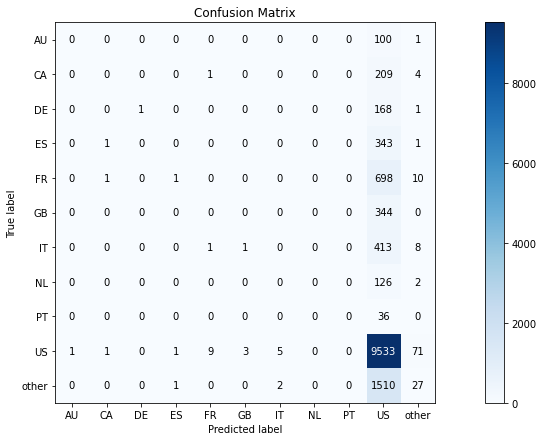

In [207]:
# accuracy
print(f' Accuracy: {accuracy_score( y_val_nn, yhat_nn )} ')

# confusion matrix
plot_confusion_matrix(y_val_nn, yhat_nn, figsize=(18,7) );

